# Gravity and Hydrostatic Equilibrium

Here we explore the reconstruction of the pressure when in hydrostatic equilibrium.

## Source terms in PPM

In the original PPM algorithm, the source terms (including gravity) were included in the characteristic projection.  If we write our system as:

$${\bf U}_t + [{\bf F}({\bf U})]_x = {\bf S}$$

The primitive variable equations would be:

$${\bf q}_t + {\bf A}({\bf q}) {\bf q}_x = {\bf H}$$

where ${\bf H}$ are the sources for the primitive variables.

The interface states with sources included in the tracing appear as:


$${\bf q}_{i+1/2,L}^{n+1/2} = \tilde{{\bf q}}_+ -
   \sum_{\nu;\lambda^{(\nu)}\ge 0} {\bf l}_i^{(\nu)} \cdot \left (
        \tilde{{\bf q}}_+ - \mathcal{I}_+^{(\nu)}({\bf q}_i) - 
                            \frac{\Delta t}{2} \mathcal{I}_+^{(\nu)}({\bf H}_i) 
       \right ) {\bf r}_i^{(\nu)}$$

$${\bf q}_{i-1/2,R}^{n+1/2} = \tilde{{\bf q}}_- -
   \sum_{\nu;\lambda^{(\nu)}\le 0} {\bf l}_i^{(\nu)} \cdot \left (
        \tilde{{\bf q}}_+ - \mathcal{I}_-^{(\nu)}({\bf q}_i) -
                            \frac{\Delta t}{2} \mathcal{I}_-^{(\nu)}({\bf H}_i)         
       \right ) {\bf r}_i^{(\nu)}$$

```{note}
We use a factor of 1/2 in front of the source term to time-center it--this is in contrast to the 
original PPM paper, and seems necessary to get 2nd order
```

## The `hse` problem setup

Here we'll look at the `hse` problem setup.  This initializes a 1D isothermal atmosphere
in hydrostatic equilibrium with constant gravity.  If we start out with zero-velocity, then
there should be no accelerations and the velocity should remain zero and the atmosphere static.
This allows us to test how well our methods preserve HSE.

In [2]:
from ppmpy.euler import Euler
from ppmpy.gravity import constant_gravity
from ppmpy.initial_conditions import hse

import matplotlib.pyplot as plt
import numpy as np

Here are the parameters needed for the atmosphere initialization:

In [3]:
params = {"base_density": 1.0, "base_pressure": 1.0, "g_const": -1.0}

Let's look at the initial atmosphere

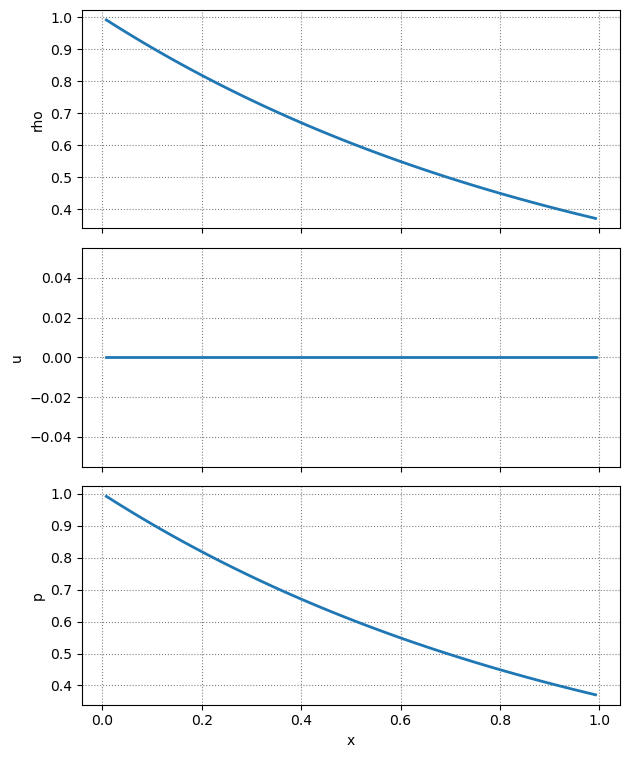

In [5]:
nx = 64
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect", params=params)
fig = e.plot_prim()

Notice that we are using reflecting boundaries at the top and bottom of the atmosphere.

```{important}
We want the reconstruction to guarantee that there is no flux through the boundaries when doing
reflection.  This means that we need to do *odd*-reflection on gravity (just like with velocity)
to ensure that the source term tracing at the lower boundary is balanced.

We also explicitly enforce reflection on the interface states:

$${\bf q}_{{\tt lo}-1/2,L} = {\bf q}_{{\tt lo}-1/2,R}$$

$${\bf q}_{{\tt hi}+1/2,R} = {\bf q}_{{\tt hi}+1/2,L}$$

## Normal PPM reconstruction

Here we use reflecting boundaries and the standard PPM reconstruction, with limiting.

In [3]:
nx = 16
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect", params=params)

We can look at the reflecting boundary conditions to see what they do to the atmosphere

Text(0.5, 0, 'x')

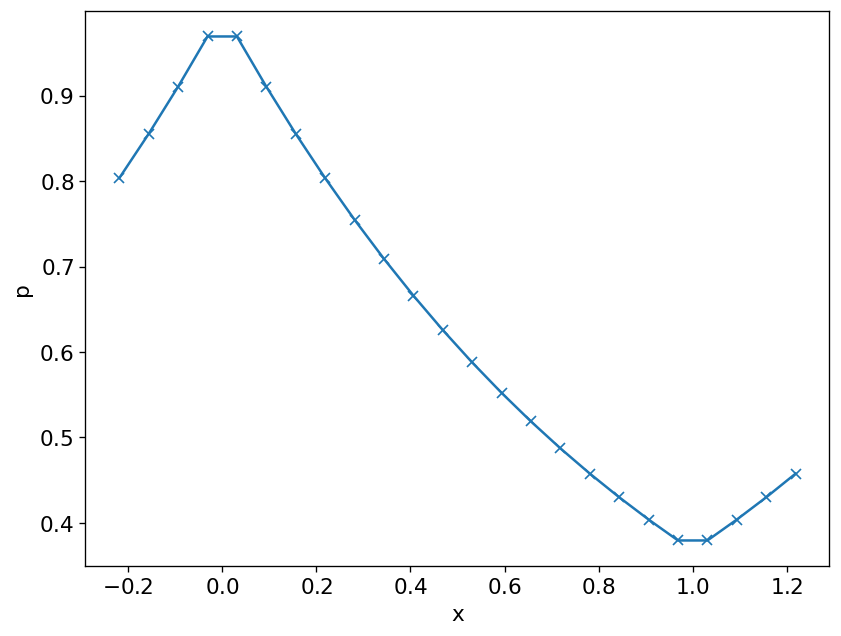

In [4]:
fig, ax = plt.subplots()
q = e.cons_to_prim()
ax.plot(e.grid.x, q[:, e.v.qp], marker="x")
ax.set_ylabel("p")
ax.set_xlabel("x")

Now we can visualize how PPM reconstructs pressure near the lower boundary

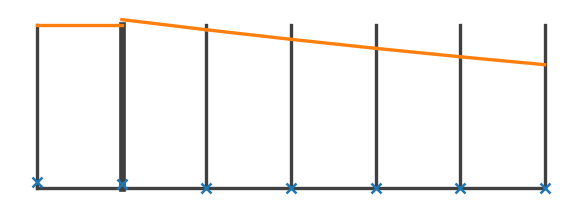

In [9]:
gp = e.grid.draw(lo_index=3, hi_index=8, stretch=2)
e.draw_prim(gp, e.v.qp)

Notice that the first interior zone has a flat profile, so there is no pressure gradient and that zone will not be in HSE
when we use the pressure coming from the Riemann problem to balance the gravitational source term.

Let's evolve this for 0.5 s to see how well HSE is maintained

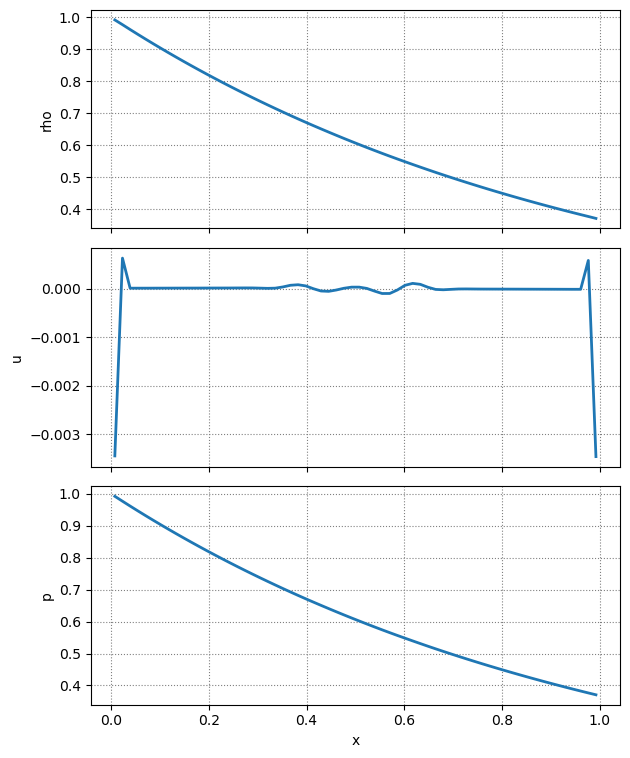

In [6]:
nx = 64
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect", params=params)
e.evolve(0.5, verbose=False)
fig = e.plot_prim()

## Hydrostatic pressure reconstruction

Now we explore the case where we have the PPM reconstruction understand HSE.  If we consider
the initial cubic interpolation to find ${\bf q}_{i\pm 1/2}$ for zone $i$, we can write that as:

$${\bf q}_{i+1/2} = f({\bf q}_{i-1}, {\bf q}_{i}, {\bf q}_{i+1}, {\bf q}_{i+2})$$

$${\bf q}_{i-1/2} = f({\bf q}_{i-2}, {\bf q}_{i-1}, {\bf q}_{i}, {\bf q}_{i+1})$$

For the pressure, we modify the ${\bf p}$ seen by the cubic by subtracting off HSE integrating from zone $i$:

$$p^\prime_i = 0$$

$$p^\prime_{i\pm 1} = p_{i\pm 1} - \int_{x_i}^{x_{i\pm 1}} \rho g dx$$

$$p^\prime_{i\pm 2} = p_{i\pm 2} - \int_{x_i}^{x_{i\pm 2}} \rho g dx$$

where we treat $\rho$ and $g$ as piecewise constant within a zone when doing the integral.

We then do the cubic interpolation on $p^\prime$.  We can then either add back the HSE pressure or leave it as a perturbation.  

First we'll consider the case where we add back the HSE pressure.  We use these values of $p^\prime_{i\pm 1/2}$
to define the parabola edges:

$$p^\prime_- = p^\prime_{i-1/2}$$

$$p^\prime_+ = p^\prime_{i+1/2}$$

and then do the PPM limiting on them as needed.  We then add back the HSE pressure
to the parabola edge values:

$$p_- = p^\prime_- + p_i  - \frac{\Delta x}{2} \rho_i g_i$$

$$p_+ = p^\prime_+ + p_i  + \frac{\Delta x}{2} \rho_i g_i$$

```{note}
With this HSE reconstruction, the interface state ${\bf q}_{i+1/2}$ seen by zone $i$ immediately after
the cubic interpolation is no longer the same as that seen by zone $i+1$.
```

In [7]:
nx = 16
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          use_hse_reconstruction=True,
          bc_left_type="reflect", bc_right_type="reflect", params=params)

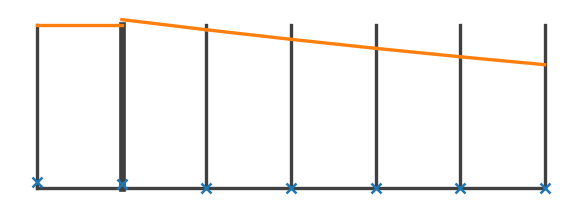

In [8]:
gp2 = e.grid.draw(lo_index=3, hi_index=8, stretch=2)
e.draw_prim(gp2, e.v.qp)

In this case, we see that the pressure in the first interior zone has a gradient that matches the needed HSE pressure gradient.

Now let's evolve this to see how well HSE is maintained with this reconstruction

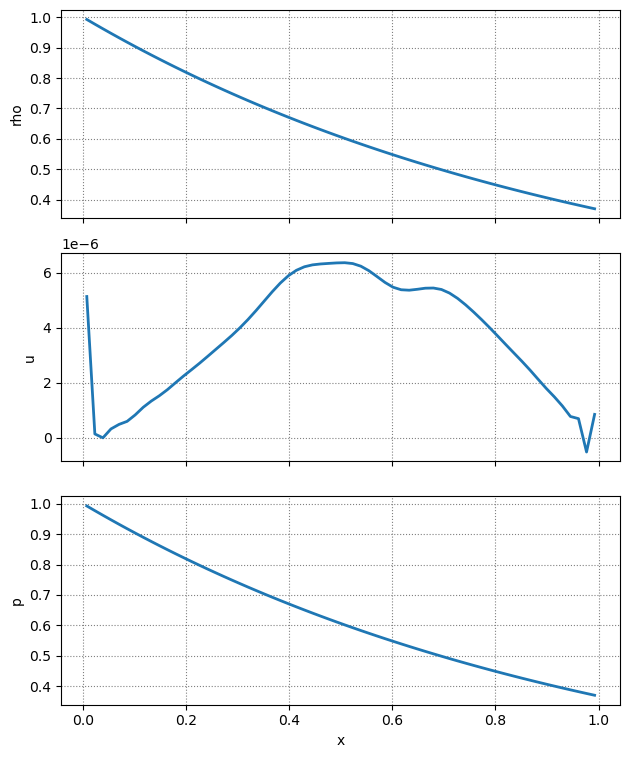

In [8]:
nx = 64
e = Euler(nx, 0.5, init_cond=hse,
          grav_func=constant_gravity,
          use_hse_reconstruction=True,
          bc_left_type="reflect", bc_right_type="reflect", params=params)
e.evolve(0.5, verbose=False)
fig = e.plot_prim()

It is much better--the velocity is 3 orders-of-magnitude smaller.  But we can actually do better
if we don't include the HSE pressure in the characteristic projection.